DATA SYTHENTISING AND PREPROCESSING HAS BEEN DONE LOCALLY

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**FEATURE ENGINEERING AND MODEL CONFIGURATION**

In [2]:
!pip install numpy # Run if numpy not installed
!pip install scipy # Run if scipy not installed
import os
from google.colab import drive # Keep if using Colab
import numpy as np
import pandas as pd
import torch
!pip install --upgrade darts # Run if darts not installed/needs update
!pip install pytorch_lightning # Run if not installed
import pytorch_lightning as pl
from darts import TimeSeries
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from darts.utils.losses import QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pickle # Keep if saving scalers

# --- Configuration ---

# !! UPDATE FILEPATHS !!
# Paths to the five CSV files to combine
filepath_orig = "/content/drive/MyDrive/tft_ready_data_darts.csv" # Original file 1
filepath_july = "/content/drive/MyDrive/tft_ready_data_darts_JULY.csv" # Original file 2
filepath_new1 = "/content/drive/MyDrive/tft_ready_data_darts_AUG.csv" # <--- UPDATE PATH
filepath_new2 = "/content/drive/MyDrive/tft_ready_data_darts_SEP.csv" # <--- UPDATE PATH
filepath_new3 = "/content/drive/MyDrive/tft_ready_data_darts_OCT.csv" # <--- UPDATE PATH

# Mount drive if using Colab
drive.mount('/content/drive')
gdrive_path = '/content/drive/MyDrive/DORC_tft_REF_training_150d' # Example Google Drive path
os.makedirs(gdrive_path, exist_ok=True)
model_name = "DORC_TFT_FORCASTOR_v5_150d" # New model name for combined 150d run
work_dir_model = os.path.join(gdrive_path, model_name)

# --- Model Hyperparameters ---
# Set based on ~150 days total, target min length 37 (input=30, output=7)
input_chunk_length = 30   # Use 30 days history
output_chunk_length = 7   # Predict 7 days ahead
# Required minimum length = 30 + 7 = 37

n_epochs = 50             # Can increase epochs slightly with more data
batch_size = 64
learning_rate = 0.0001
hidden_size = 32
attention_head_size = 4
dropout = 0.1
hidden_continuous_size = 16

validation_split_percentage = 0.7 # Use 70/30 split (should give >37 days for validation)
random_seed = 42

# --- Seed ---
pl.seed_everything(random_seed, workers=True)
np.random.seed(random_seed)
torch.manual_seed(random_seed)


# --- Load AND COMBINE Preprocessed Data ---
print("Loading and combining data...")
all_dfs = []
file_paths = [filepath_orig, filepath_july, filepath_new1, filepath_new2, filepath_new3]

for i, fp in enumerate(file_paths):
    print(f"Loading data from file {i+1}: {fp}")
    try:
        df_temp = pd.read_csv(fp, parse_dates=['date'], index_col='date')
        if not isinstance(df_temp.index, pd.DatetimeIndex):
             print(f"Warning: Index for {fp} is not DatetimeIndex after loading. Attempting conversion.")
             df_temp.index = pd.to_datetime(df_temp.index)
        all_dfs.append(df_temp)
        print(f"  - Loaded shape: {df_temp.shape}")
    except FileNotFoundError:
        print(f"Error: File not found at {fp}. Skipping this file.")
    except KeyError:
        print(f"Error: 'date' column not found in {fp}. Skipping this file.")
    except Exception as e:
        print(f"Error loading CSV {fp}: {e}. Skipping this file.")

if not all_dfs:
    print("Error: No data files were successfully loaded. Exiting.")
    exit()

# Concatenate the dataframes
print("\nConcatenating loaded DataFrames...")
df = pd.concat(all_dfs, axis=0)

# checking for NAN values
print("NaN check in combined df:", df.isnull().sum().sum())
print("Inf check in combined df:", np.isinf(df.select_dtypes(include=np.number)).sum().sum())

# Ensure the index is sorted and unique (important after concat)
print("Sorting index and removing duplicates...")
df = df.sort_index()
initial_len = len(df)
if not df.index.is_unique:
    print("Warning: Duplicate dates found after concatenation. Keeping first occurrence.")
    df = df[~df.index.duplicated(keep='first')]
    print(f"  - Removed {initial_len - len(df)} duplicate date rows.")

print(f"\nCombined data loaded successfully. Shape: {df.shape}")
print(f"Combined date range: {df.index.min()} to {df.index.max()}")
print(f"Total days in combined dataset: {len(df)}")

# --- Timestamping Verification ---
print(f"Final DataFrame index type: {type(df.index)}")
if not isinstance(df.index, pd.DatetimeIndex):
     print("Error: Final combined DataFrame index is not a DatetimeIndex. Cannot proceed.")
     exit()
# --- End Timestamping Verification ---

# print("Columns:", df.columns.tolist()) # Verify columns are consistent

# --- Identify Column Types Dynamically ---
print("\nIdentifying column types...")
target_cols = [col for col in df.columns if col.startswith('target_')]
future_covariate_cols = [col for col in df.columns if col.startswith('future_')]
known_non_past_cols = set(target_cols + future_covariate_cols + ['time_idx'])
past_covariate_cols = [col for col in df.columns if col not in known_non_past_cols]
print(f"Identified {len(target_cols)} target columns: {target_cols[:5]}...")
print(f"Identified {len(future_covariate_cols)} future covariate columns: {future_covariate_cols}")
print(f"Identified {len(past_covariate_cols)} past covariate columns: {past_covariate_cols[:5]}...")

# --- Data Splitting ---
split_point = df.index[int(validation_split_percentage * len(df))]
train_df = df.loc[df.index <= split_point]
val_df = df.loc[df.index > split_point]
print(f"\nSplitting combined data at date: {split_point}")
print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")

# --- DETAILED NAN CHECK BEFORE SCALING ---
print("\n--- NaN Check Before Scaling ---")
print(f"NaNs in full df: {df.isnull().sum().sum()}")
print(f"NaNs in train_df: {train_df.isnull().sum().sum()}")
print(f"NaNs in val_df: {val_df.isnull().sum().sum()}")

if df.isnull().sum().sum() > 0:
    print("\nColumns with NaNs in full df:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    # --- APPLY FILLING HERE ROBUSTLY ---
    print("Applying ffill().bfill() to combined DataFrame 'df' AGAIN...")
    df = df.ffill().bfill()
    # Re-split after filling
    train_df = df.loc[df.index <= split_point]
    val_df = df.loc[df.index > split_point]
    print(f"NaNs in full df after fill: {df.isnull().sum().sum()}")
    print(f"NaNs in train_df after fill: {train_df.isnull().sum().sum()}")
    print(f"NaNs in val_df after fill: {val_df.isnull().sum().sum()}")
    # --- END REINFORCED FILLING ---
else:
    print("No NaNs found in df before splitting.")
print("--- End NaN Check ---")
# --- END DETAILED NAN CHECK ---

# --- Critical Length Check (using combined data split) ---
min_required_train_length = input_chunk_length + output_chunk_length
min_required_val_length = input_chunk_length + output_chunk_length
print(f"Required minimum series length for one sample: {min_required_train_length}")
print(f"Actual training data length: {len(train_df)}")
print(f"Actual validation data length: {len(val_df)}")

if len(train_df) < min_required_train_length:
    raise ValueError(f"Training data length ({len(train_df)}) is less than required minimum ({min_required_train_length}). Adjust split percentage or chunk lengths.")
if len(val_df) < min_required_val_length:
     raise ValueError(f"Validation data length ({len(val_df)}) is less than required minimum ({min_required_val_length}). Adjust split percentage or chunk lengths.")
# --- End Length Check ---

# --- Data Scaling (using combined data split) ---
print("\nScaling data...")
# (Scaling logic remains the same, just operates on the new train_df/val_df)
# Target Scaler
target_scaler = Scaler(MinMaxScaler())
if not all(col in train_df.columns for col in target_cols): raise ValueError("Missing target columns in train_df.")
train_target_ts = TimeSeries.from_dataframe(train_df, value_cols=target_cols, freq='D')
train_target_scaled = target_scaler.fit_transform(train_target_ts)
print(f"Train target TimeSeries length: {len(train_target_scaled)}")

if not all(col in val_df.columns for col in target_cols): raise ValueError("Missing target columns in val_df.")
val_target_ts = TimeSeries.from_dataframe(val_df, value_cols=target_cols, freq='D')
val_target_scaled = target_scaler.transform(val_target_ts)
print(f"Validation target TimeSeries length: {len(val_target_scaled)}")

full_target_ts = TimeSeries.from_dataframe(df, value_cols=target_cols, freq='D')
full_target_scaled = target_scaler.transform(full_target_ts)

# Past Covariates Scaler
if past_covariate_cols:
    print(f"Scaling {len(past_covariate_cols)} past covariates...")
    past_cov_scaler = Scaler(MinMaxScaler())
    if not all(col in train_df.columns for col in past_covariate_cols): raise ValueError("Missing past covariate columns in train_df.")
    train_past_cov_ts = TimeSeries.from_dataframe(train_df, value_cols=past_covariate_cols, freq='D')
    train_past_cov_scaled = past_cov_scaler.fit_transform(train_past_cov_ts)
    print(f"Train past covariates TimeSeries length: {len(train_past_cov_scaled)}")

    if not all(col in val_df.columns for col in past_covariate_cols): raise ValueError("Missing past covariate columns in val_df.")
    val_past_cov_ts = TimeSeries.from_dataframe(val_df, value_cols=past_covariate_cols, freq='D')
    val_past_cov_scaled = past_cov_scaler.transform(val_past_cov_ts)
    print(f"Validation past covariates TimeSeries length: {len(val_past_cov_scaled)}")

    full_past_cov_ts = TimeSeries.from_dataframe(df, value_cols=past_covariate_cols, freq='D')
    full_past_cov_scaled = past_cov_scaler.transform(full_past_cov_ts)
else:
    print("No past covariates identified.")
    train_past_cov_scaled, val_past_cov_scaled, full_past_cov_scaled = None, None, None

# Future Covariates (NO SCALING)
if future_covariate_cols:
    print(f"Preparing {len(future_covariate_cols)} future covariates (no scaling)...")
    if not all(col in train_df.columns for col in future_covariate_cols): raise ValueError("Missing future covariate columns in train_df.")
    train_fut_cov = TimeSeries.from_dataframe(train_df, value_cols=future_covariate_cols, freq='D')
    print(f"Train future covariates TimeSeries length: {len(train_fut_cov)}")

    if not all(col in val_df.columns for col in future_covariate_cols): raise ValueError("Missing future covariate columns in val_df.")
    val_fut_cov = TimeSeries.from_dataframe(val_df, value_cols=future_covariate_cols, freq='D')
    print(f"Validation future covariates TimeSeries length: {len(val_fut_cov)}")

    full_fut_cov = TimeSeries.from_dataframe(df, value_cols=future_covariate_cols, freq='D')
else:
    print("No future covariates identified.")
    train_fut_cov, val_fut_cov, full_fut_cov = None, None, None

print("Scaling/Preparation complete.")
print(f"Outputs will be saved to: {gdrive_path}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/664.8 MB 105.1 MB/s eta 0:00:06
ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'pytorch_lightning'

**MODEL TRAINING**

In [ ]:
# Defining Darts TFT Model

# Define optimizing parameters
optimizer_kwargs = {"lr": learning_rate}

# Define PyTorch Lightning Trainer arguments
lr_scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau
pl_trainer_kwargs = {
    "accelerator": "auto",
    "gradient_clip_val": 0.1,
    "max_epochs": n_epochs,
    "callbacks": [
        EarlyStopping(monitor="val_loss", patience=15, mode="min", verbose=True),
        LearningRateMonitor(logging_interval="epoch"),
    ],
    # Enable checkpointing (Darts handles the default checkpoint callback)
    "enable_checkpointing": True,
}

# Defining the loss function
# Default quantiles: [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
# loss_fn = QuantileLoss()
likelihood=QuantileRegression() # using likelihood as alternative
# Model definition
model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=hidden_size,
    lstm_layers=2,
    num_attention_heads=attention_head_size,
    dropout=dropout,
    batch_size=batch_size,
    n_epochs=n_epochs,
    add_relative_index=False, # Darts TFT adds this automatically based on time_idx
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={"lr": learning_rate},
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 5, "factor": 0.2},
    likelihood=QuantileRegression(),
    random_state=random_seed,
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name=model_name, # Use defined model_name
    work_dir=work_dir_model, # Use specific model directory
    save_checkpoints=True, # Explicitly save checkpoints
    force_reset=True,      # Start fresh if model exists
    log_tensorboard=True
)

print("\n--- Starting Model Training ---")
# Training
model.fit(
    series=train_target_scaled,
    past_covariates=train_past_cov_scaled,
    future_covariates=train_fut_cov,
    val_series=val_target_scaled,
    val_past_covariates=val_past_cov_scaled,
    val_future_covariates=val_fut_cov,
    verbose=True,
    # num_loader_workers=2 # Optional: Adjust based on system
)

print("\n--- Training Complete ---")
print(f"Model saved in: {work_dir_model}")


--- Starting Model Training ---


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4.966


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 4.882


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 4.812


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 4.749


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 4.694


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 4.642


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 4.593


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 4.542


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 4.486


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 4.428


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 4.372


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 4.316


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 4.260


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 4.204


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 4.147


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 4.089


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 4.033


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 3.961


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 3.882


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 3.833


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 3.783


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 3.733


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 3.684


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 3.637


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 3.589


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 3.539


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 3.490


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 3.441


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 3.394


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 3.351


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 3.310


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 3.272


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 3.235


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 3.198


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 3.162


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 3.126


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 3.089


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 3.053


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 3.018


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 2.984


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 2.950


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 2.915


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 2.882


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 2.849


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 2.814


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 2.779


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 2.746


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 2.714


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 2.683


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 2.652
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.



--- Training Complete ---
Model saved in: /content/drive/MyDrive/DORC_tft_REF_training_150d/DORC_TFT_FORCASTOR_v5_150d


**RETRAINING ON SAME DATA WITH MORE STEPS**

IMPORTING AND LOADING MODEL AND ITS SCALARS

In [ ]:
import pickle

try:
    with open(os.path.join(gdrive_path, "target_scaler.pkl"), "rb") as f:
        target_scaler = pickle.load(f)
    # Loading past_cov_scaler if you used it
    if os.path.exists(os.path.join(gdrive_path, "past_cov_scaler.pkl")):
         with open(os.path.join(gdrive_path, "past_cov_scaler.pkl"), "rb") as f:
            past_cov_scaler = pickle.load(f)
    else:
        past_cov_scaler = None
    # Loading future covariate setup (e.g., encoder) if applicable
    print("Original scalers loaded.")
except FileNotFoundError:
    print("ERROR: Original scalers not found. Cannot proceed with retraining without them.")
    # Handle error
    exit()

ERROR: Original scalers not found. Cannot proceed with retraining without them.


MODEL LOADING

In [3]:
print(f"Loading model '{model_name}' from {work_dir_model}...")

try:
    # Load the best checkpoint saved by the trainer
    loaded_model = TFTModel.load_from_checkpoint(
        model_name=model_name,
        work_dir=gdrive_path,
        best=True  # Load the checkpoint marked as best by the monitor (e.g., lowest val_loss)
    )
    print("Model loaded successfully.")
    # The loaded model retains its architecture, trained weights, optimizer state, etc.

except FileNotFoundError:
    print(f"ERROR: Checkpoint for model '{model_name}' not found in {work_dir_model}.")
    # Handle error
    exit()
except Exception as e:
    print(f"ERROR: Failed to load checkpoint. {e}")
    # Handle error
    exit()

Loading model 'DORC_TFT_FORCASTOR_v5_150d' from /content/drive/MyDrive/DORC_tft_REF_training_150d/DORC_TFT_FORCASTOR_v5_150d...
Model loaded successfully.


RECONFIGURATION AND RETRAINING

In [6]:
"""Configure Retraining Parameters"""

new_epochs = 20 # Train for an additional 20 epochs
total_epochs = loaded_model.n_epochs + new_epochs  # Calculate total epochs
optimizer_kwargs = {"lr": 0.001}

# Re-defining callbacks
retrain_pl_trainer_kwargs = {
    "accelerator": "auto",
    "gradient_clip_val": 0.1,
    "max_epochs": total_epochs,
    "callbacks": [
        # Use potentially adjusted callbacks or reuse original ones
        EarlyStopping(monitor="val_loss", patience=10, mode="min", verbose=True), # Maybe shorter patience
        LearningRateMonitor(logging_interval="epoch"),
    ],
    "enable_checkpointing": True, # Continue saving checkpoints
}

# Updating the kwargs in the loaded model
loaded_model.pl_trainer_kwargs = retrain_pl_trainer_kwargs


# Retrain the Model
print(f"Resuming training for {new_epochs} additional epochs...")
loaded_model.fit(
    series=train_target_scaled, # The scaled training target series
    past_covariates=train_past_cov_scaled,
    future_covariates=train_fut_cov,
    val_series=val_target_scaled, # The scaled validation target series
    val_past_covariates=val_past_cov_scaled,
    val_future_covariates=val_fut_cov,
    epochs=new_epochs, # Specify how many *more* epochs to train
    # pl_trainer_kwargs=retrain_pl_trainer_kwargs,
    # optimizer_cls=torch.optim.Adam,
    # optimizer_kwargs=optimizer_kwargs,
    # log_tensorboard=True,
    verbose=True,
)

print("Retraining finished.")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Resuming training for 20 additional epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 2.630


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.606


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 2.580


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 2.554


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 2.528


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.504


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.480


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.457


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.433


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 2.409


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.385


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.361


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.337


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.314


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.291


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.267


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.244


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.222


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 2.200


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 2.178
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Retraining finished.


MODEL EVALUATION

In [10]:
import pandas as pd
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mae, mape
import os


print("\n--- Predicting on Validation Set ---")

# Loading the best model checkpoint saved by the trainer
print(f"Loading best model '{model_name}' from {gdrive_path}...")
try:
    loaded_model = TFTModel.load_from_checkpoint(
            model_name=model_name,
            work_dir=gdrive_path,
            best=True  # Load the checkpoint marked as best
        )
    best_model = loaded_model # Using the loaded model
    print("Model loaded.")
except Exception as e:
    print(f"Error loading model: {e}")
    # Handle error, maybe exit or raise
    exit()

"""Data prep"""

# Determining prediction length based on the validation set
n_predict = len(val_target_scaled)
print(f"Validation set length: {n_predict} steps")
# Checking if n_predict exceeds the model's output_chunk_length
if n_predict > best_model.output_chunk_length:
     print(f"Warning: Validation set length ({n_predict}) is longer than model output chunk length ({best_model.output_chunk_length}). Adjusting n_predict.")
     # Indicating an issue in how validation split was handled relative to output_chunk_length
     n_predict = best_model.output_chunk_length


predict_start_time = val_target_scaled.start_time()

# History for prediction comes from the full scaled series ending just before validation starts
pred_input_target = full_target_scaled.drop_after(predict_start_time - full_target_scaled.freq)
pred_input_past_cov = full_past_cov_scaled.drop_after(predict_start_time - full_target_scaled.freq) if full_past_cov_scaled is not None else None

# Future covariates needed for the prediction horizon [start_time, end_time]
if full_fut_cov is not None:
    # Defining the START time for future covariates needed by the encoder
    encoder_start_time_fut_cov = predict_start_time - input_chunk_length * full_fut_cov.freq - full_fut_cov.freq
    # Defining the END time for future covariates needed for the prediction horizon (remains the same)
    decoder_end_time_fut_cov = predict_start_time + (n_predict - 1) * full_fut_cov.freq

    print(f"Required future cov start (encoder): {encoder_start_time_fut_cov}")
    print(f"Required future cov end (decoder):   {decoder_end_time_fut_cov}")

    try:
        # slicing robustness
        pred_future_cov = full_fut_cov[encoder_start_time_fut_cov : decoder_end_time_fut_cov]
    except KeyError as e:
         print(f"Error slicing future covariates: {e}")
         print("Check if the calculated start/end times exist within the full_fut_cov range.")
         exit()

else:
    pred_future_cov = None

print(f"Predicting {n_predict} steps starting from {predict_start_time}")

# Checking the length of the SLICED future covariates
if pred_future_cov is not None:
    print(f"Length of provided future_covariates after slicing: {len(pred_future_cov)}")
    if len(pred_future_cov) == 0:
        print(f"Error: Sliced future covariates resulted in an empty series. Check slicing logic and bounds of full_fut_cov.")
        exit()
    # More robust check: Ensure the start time matches
    if pred_future_cov.start_time() != encoder_start_time_fut_cov:
       print(f"Warning: Sliced future covariates start time ({pred_future_cov.start_time()}) doesn't exactly match required start ({encoder_start_time_fut_cov}). This might indicate boundary issues.")

# Generating Predictions
predictions_scaled = best_model.predict(
    n=n_predict,
    series=pred_input_target,
    past_covariates=pred_input_past_cov,
    future_covariates=pred_future_cov,
    num_samples=100, # For probabilistic forecasts
    verbose=True
)

print(f"\nPrediction output type: {type(predictions_scaled)}")
print(f"Prediction output components (Targets): {predictions_scaled.components}")
print(f"Prediction output length: {len(predictions_scaled)}")
print(f"Prediction output quantiles available: {predictions_scaled.quantile_timeseries()}") # Check if quantiles are present


# Inversing transform and Evaluation

if hasattr(predictions_scaled, 'quantile_timeseries'):
     print("Probabilistic forecast detected (quantile_timeseries method available). Extracting median.")
     # Extract the median (0.5 quantile) prediction
     median_prediction_scaled = predictions_scaled.quantile_timeseries(quantile=0.5)
else:
    # To handle case where maybe only point forecast was generated (num_samples=1 or likelihood wasn't probabilistic)
    print("Warning: Prediction does not appear probabilistic or quantile method is missing. Using main prediction series.")
    # Assuming the main series is the point forecast in this case
    median_prediction_scaled = predictions_scaled


# Inverse transform using the original target scaler
predictions_inv = target_scaler.inverse_transform(median_prediction_scaled)

print("\nSample of Inverse-Transformed Predictions (Median):")
print(predictions_inv.to_dataframe().head())

# Get actual validation data as TimeSeries for comparison
actual_val_ts = TimeSeries.from_dataframe(val_df, value_cols=target_cols)

# Calculating MAE & MAPE for the median prediction
if len(actual_val_ts) != len(predictions_inv):
    print(f"Warning: Length mismatch between actual ({len(actual_val_ts)}) and prediction ({len(predictions_inv)}). Metrics might be inaccurate.")
    min_len = min(len(actual_val_ts), len(predictions_inv))
    actual_val_ts = actual_val_ts[:min_len]
    predictions_inv = predictions_inv[:min_len]


mae_val = mae(actual_val_ts, predictions_inv)
# mape_val = mape(actual_val_ts, predictions_inv)

print(f"\nValidation MAE (Median Forecast): {mae_val:.4f}")
# print(f"Validation MAPE (Median Forecast): {mape_val:.4f}%")


--- Predicting on Validation Set ---
Loading best model 'DORC_TFT_FORCASTOR_v5_150d' from /content/drive/MyDrive/DORC_tft_REF_training_150d...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model loaded.
Validation set length: 46 steps
Required future cov start (encoder): 2024-08-17 00:00:00
Required future cov end (decoder):   2024-09-23 00:00:00
Predicting 7 steps starting from 2024-09-17 00:00:00
Length of provided future_covariates after slicing: 38


Predicting: |          | 0/? [00:00<?, ?it/s]


Prediction output type: <class 'darts.timeseries.TimeSeries'>
Prediction output components (Targets): Index(['target_RCO_Pour Point', 'target_RCO_37.35',
       'target_RCO_DESALTED CRUDE', 'target_Kero_Yield',
       'target_Light_Diesel_Yield', 'target_Heavy_Diesel_Yield',
       'target_RCO_Yield', 'target_RCO_flow', 'target_Heavy_Diesel_flow',
       'target_Light_Diesel_flow', 'target_Kero_flow', 'target_Naphtha_flow'],
      dtype='object', name='component')
Prediction output length: 7
Prediction output quantiles available: <TimeSeries (DataArray) (date: 7, component: 12, sample: 1)> Size: 672B
array([[[ 0.40620882],
        [ 0.17447201],
        [ 0.03028364],
        [ 0.39695608],
        [ 0.27565926],
        [ 0.17344978],
        [ 0.32803286],
        [ 0.17751055],
        [ 0.17884452],
        [ 0.39004121],
        [ 0.35426045],
        [ 0.24843542]],

       [[ 0.39635305],
        [ 0.20150666],
        [ 0.03363166],
        [ 0.42860123],
        [ 0.28838552]

**VISUALIZATION**

--- Visualizing Predictions vs Actuals ---


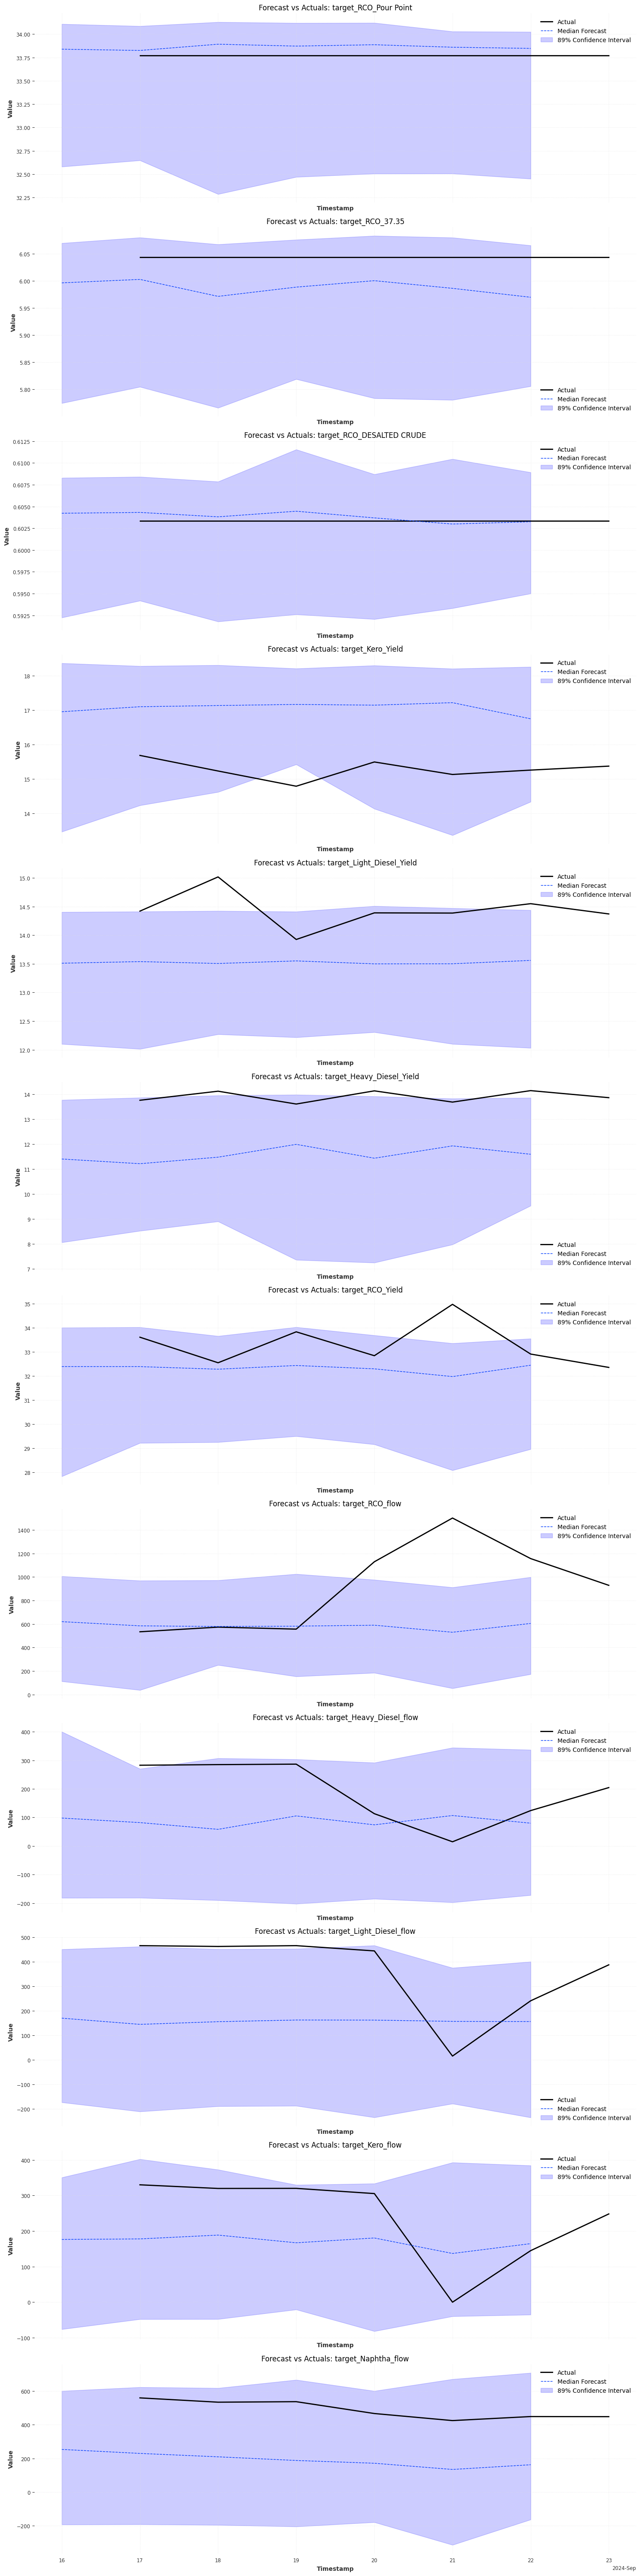

In [11]:
import matplotlib.pyplot as plt

print("--- Visualizing Predictions vs Actuals ---")

# Determine the number of steps predicted (should match predictions_inv length)
num_steps_predicted = len(predictions_inv)

# Slice the actual validation data to match the prediction length for plotting
actual_val_ts_slice = actual_val_ts[:num_steps_predicted]

# Check if lengths match now (they should after slicing)
if len(actual_val_ts_slice) != len(predictions_inv):
    print(f"Warning: Length mismatch persists after slicing. Actual slice: {len(actual_val_ts_slice)}, Prediction: {len(predictions_inv)}")
    # Adjust shorter one if needed, though slicing should handle this
    min_len = min(len(actual_val_ts_slice), len(predictions_inv))
    actual_val_ts_slice = actual_val_ts_slice[:min_len]
    predictions_inv = predictions_inv[:min_len]


# --- Create Plots ---
num_targets = len(target_cols)
fig, axes = plt.subplots(nrows=num_targets, ncols=1, figsize=(15, 5 * num_targets), sharex=True)

# Handle the case of a single target (axes is not an array)
if num_targets == 1:
    axes = [axes]

# Loop through each target variable
for i, target_name in enumerate(target_cols):
    ax = axes[i]

    # Find the matching component name in predictions_inv
    pred_component_name = None
    for col in predictions_inv.components:
        if col.startswith(target_name):
            pred_component_name = col
            break
    if pred_component_name is None:
         print(f"Warning: Could not find matching component for {target_name} in predictions_inv columns: {predictions_inv.components}. Skipping plot for this target.")
         continue

    # Plot Actual Data
    actual_val_ts_slice[target_name].plot(ax=ax, label="Actual", lw=2)

    # Plot Median Forecast
    predictions_inv[pred_component_name].plot(ax=ax, label="Median Forecast", lw=1, linestyle='--')


    # --- Optional: Plot Uncertainty Intervals (Requires predictions_scaled and target_scaler) ---
    if 'predictions_scaled' in locals() and 'target_scaler' in locals() and hasattr(predictions_scaled, 'quantile_timeseries'):
        try:
            # Define desired quantiles for the interval (e.g., 5% and 95% for 90% interval)
            lower_quantile = 0.05
            upper_quantile = 0.95

            # Extract scaled quantile timeseries
            lower_q_scaled = predictions_scaled.quantile_timeseries(quantile=lower_quantile)
            upper_q_scaled = predictions_scaled.quantile_timeseries(quantile=upper_quantile)

            # Inverse transform the scaled quantiles
            lower_q_inv = target_scaler.inverse_transform(lower_q_scaled)
            upper_q_inv = target_scaler.inverse_transform(upper_q_scaled)

            # Get the correct component names for the quantiles
            pred_lower_component_name = None
            pred_upper_component_name = None
            for col in lower_q_inv.components: # Assuming component names match between lower/upper
                if col.startswith(target_name):
                    pred_lower_component_name = col
                    # Construct the expected upper name based on the lower one (replace quantile value)
                    pred_upper_component_name = col.replace(f"_{lower_quantile}", f"_{upper_quantile}")
                    break

            if pred_lower_component_name and pred_upper_component_name and pred_upper_component_name in upper_q_inv.components:
                 # Plot the uncertainty interval using fill_between
                 ax.fill_between(
                     lower_q_inv.time_index, # X-axis (time)
                     lower_q_inv[pred_lower_component_name].values().flatten(), # Lower bound values
                     upper_q_inv[pred_upper_component_name].values().flatten(), # Upper bound values
                     color='blue',
                     alpha=0.2, # Transparency
                     label=f"{int((upper_quantile-lower_quantile)*100)}% Confidence Interval"
                 )
            else:
                 print(f"Warning: Could not find matching quantile components for {target_name}. Skipping interval plot.")

        except Exception as e:
            print(f"Could not plot uncertainty intervals for {target_name}: {e}")
    # --- End Optional Uncertainty Plot ---


    ax.set_title(f"Forecast vs Actuals: {target_name}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()